## Repo Dependency Parser

As a new developer, often one finds that when joining a new codebase, a key aspect of contributing is understanding the repository. In order to do that, one typically crawls code for hours figuring out what connects to what. However once the codebase reaches a certain size, it becomes increasingly infeasible to do this. In most cases a reasonable compromise is to just learn as needed, contributing incrementally and relying on feedback to develop a complete feature. Nonetheless, there are repositories in which for one reason or other there are necessary dependencies that touch on more than one subsystems. Understanding those 'higher order' dependencies is crucial, especially in open source code that is security sensitive, e.g. cryptocurrency codebases. In order to facilitate cross polination of ideas between different codebases, it is therefore important to provide an open source tool that can be used to study codebases and examine their internal structure in a more visual and hierarchical way. Anyone who's ever had to understand a complex system would ideally be able to save on the sticky notes and whiteboard markers using this tool.

In [1]:
import os
sep = os.path.sep
local_directory = ".."+sep+"Divi" # Needs to be relative to the notebook and using
                                  # the separators according to the OS you're working with
source_file=".cpp"
header_file=".h"

In [2]:
import re
class RepoReader:
    
    def __init__(self,dir,header_ext,source_ext):
        self.re = re.compile("^#include [<\"]{1,}(.+)[>\"]{1,}")
        self.used_by = {}
        self.all_files = set()
        self.exception = set()
        
        self.sep=os.path.sep
        self.dir=os.path.normpath(dir)
        self.header_ext=header_ext
        self.source_ext=source_ext
        self.header_filenames = []
        self.source_filenames = []
        self._read_filenames()
    
    def _read_filenames(self):
        all_files =[os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.dir)) for f in fn]
        for file in all_files:
            should_record = False
            if file.endswith(self.header_ext):
                self.header_filenames.append(\
                    file)
                should_record=True
            elif file.endswith(self.source_ext):
                self.source_filenames.append(\
                    file)
                should_record=True
                
            if should_record:
                self._extract_includes(file)
                self.all_files.add(file)
    
    def _extract_includes(self,filename):
        with open(filename, errors='ignore') as search:
            for line in search:
                x=self.re.match(line)
                if x is not None:
                    included_file = x.groups(0)[0]
                    if filename in self.used_by:
                        self.used_by[filename].append(included_file)
                    else:
                        self.used_by[filename] = [included_file]                        
        search.close()
    
    def find_file(self, filename,mode=True):
        filename=os.path.normpath(filename)
        filename=filename.split(self.sep)[-1]
        target_re = "(.+"+self.sep+self.sep+")?"+filename
        for f in self.all_files:
            if re.match(target_re,f):
                if mode:
                    print(f)
                return True
        if mode:
            print("File not found")
        return False
    
    def add_integrity_exception(self,ignore_std_lib):
        if ignore_std_lib:
            self.exception.add(str(ignore_std_lib))
    
    def check_reference_integrity(self):
        files_found = set()
        for f in self.used_by:#i.e. it uses some files
            for used_by_f in self.used_by[f]: 
                if not self.find_file(used_by_f,False):# File was not found
                    if (used_by_f.endswith('.h') or used_by_f.endswith('.cpp')) and (not used_by_f in self.exception):
                        print("Integrity check failed!\n"\
                              "File "+str(f)+" attempts to include " + str(used_by_f))
                        return False
        return True
    
    def who_uses(self,filename):
        filename=str(os.path.normpath(filename))
        files_that_include_filename = []
        target_regex = "(.+"+self.sep+self.sep+")?(.+/)?"+filename.split(sep)[-1]
        for f in self.used_by:
            for used_file in self.used_by[f]:
                if re.match(target_regex,used_file):
                    files_that_include_filename.append(f)
        return files_that_include_filename
    
    def _create_graph(self):
        return []
        self.graph = []
        for containing_file in self.used_by:
            for used_file in self.used_by[containing_file]:
                print("containing_file: "+f)
                print("used_file: "+used_file)
                target_re = "(.+"+sep+sep+")?"+used_file.split(sep)[-1]
                print("target_re: "+target_re)
                m = [f for f in self.all_files if re.match(target_re,f)!=None]
                if len(m)!=0:
                    print(m)
                    break
                
            if len(m)!=0:
                break
                
    

In [3]:
reader=RepoReader(local_directory,header_file, source_file)

In [4]:
assert(reader.header_filenames.__len__() == 296)
assert(reader.source_filenames.__len__() == 255)

In [5]:
import json
reader.used_by['..\\Divi\\src\\script\\diviconsensus.h']

['stdint.h', 'config/divi-config.h']

In [6]:
reader.find_file("stdint.h");
reader.find_file("divi_config.h");
reader.find_file("diviconsensus.h")

..\Divi\src\leveldb\port\win\stdint.h
..\Divi\build_msvc\divi_config.h
..\Divi\src\script\diviconsensus.h


True

## Explicitly verifying what 'external' dependencies are being added

In [7]:
#..\Divi\src\arith_uint256.cpp
reader.add_integrity_exception("stdio.h")
reader.add_integrity_exception("string.h")
reader.add_integrity_exception("assert.h")

#..\Divi\src\bip39.cpp
reader.add_integrity_exception("openssl/evp.h")

#..\Divi\src\bloom.cpp
reader.add_integrity_exception("math.h")
reader.add_integrity_exception("stdlib.h")
#..\Divi\src\clientversion.cpp
reader.add_integrity_exception("obj/build.h")

# Various files inside the Divi/src/ folder related to
# an include guard HAVE_CONFIG_H
reader.add_integrity_exception("config/divi-config.h")
reader.add_integrity_exception("winsock2.h")
reader.add_integrity_exception("mswsock.h")
reader.add_integrity_exception("windows.h")
reader.add_integrity_exception("ws2tcpip.h")
reader.add_integrity_exception("fcntl.h")

# sys/mman.cpp only found on linux
reader.add_integrity_exception("sys/mman.h")
reader.add_integrity_exception("sys/select.h")
reader.add_integrity_exception("sys/socket.h")
reader.add_integrity_exception("sys/types.h")
reader.add_integrity_exception("net/if.h")
reader.add_integrity_exception("netinet/in.h")
reader.add_integrity_exception("netinet/tcp.h")
reader.add_integrity_exception("arpa/inet.h")
reader.add_integrity_exception("ifaddrs.h")

reader.add_integrity_exception("limits.h")
reader.add_integrity_exception("netdb.h")
reader.add_integrity_exception("unistd.h")
reader.add_integrity_exception("errno.h")
reader.add_integrity_exception("event2/buffer.h")
reader.add_integrity_exception("event2/keyvalq_struct.h")
reader.add_integrity_exception("ext/stdio_filebuf.h")
reader.add_integrity_exception("sys/stat.h")
reader.add_integrity_exception("signal.h")
reader.add_integrity_exception("event2/thread.h")
reader.add_integrity_exception("event2/bufferevent.h")
reader.add_integrity_exception("event2/bufferevent.h")
reader.add_integrity_exception("poll.h")
reader.add_integrity_exception("miniupnpc/miniupnpc.h")
reader.add_integrity_exception("miniupnpc/miniwget.h")
reader.add_integrity_exception("miniupnpc/upnpcommands.h")
reader.add_integrity_exception("miniupnpc/upnperrors.h")
reader.add_integrity_exception("wincrypt.h")
reader.add_integrity_exception("sys/syscall.h")
reader.add_integrity_exception("sys/sysctl.h")
reader.add_integrity_exception("cpuid.h")
reader.add_integrity_exception("openssl/err.h")
reader.add_integrity_exception("openssl/rand.h")
reader.add_integrity_exception("event2/event.h")
reader.add_integrity_exception("libkern/OSByteOrder.h")
reader.add_integrity_exception("immintrin.h")
reader.add_integrity_exception("stddef.h")
reader.add_integrity_exception("stdarg.h")
reader.add_integrity_exception("libkern/OSAtomic.h")
reader.add_integrity_exception("pthread.h")
reader.add_integrity_exception("snappy.h")
reader.add_integrity_exception("malloc.h")
reader.add_integrity_exception("ecmult_static_context.h")
reader.add_integrity_exception("libsecp256k1-config.h")
reader.add_integrity_exception("gmp.h")
reader.add_integrity_exception("jni.h")
reader.add_integrity_exception("event2/http.h")
reader.add_integrity_exception("sys/resource.h")
reader.add_integrity_exception("sys/wait.h")
reader.add_integrity_exception("sys/prctl.h")

# Case exception for the Linux vs. Windows situation where case matters?
reader.add_integrity_exception("Windows.h")

# Using include sorcery to bring in test data :C
reader.add_integrity_exception("bench/data/block413567.raw.h")
reader.add_integrity_exception("test/data/base58_encode_decode.json.h")
reader.add_integrity_exception("test/data/blockfilters.json.h")
reader.add_integrity_exception("test/data/key_io_invalid.json.h")
reader.add_integrity_exception("test/data/key_io_valid.json.h")
reader.add_integrity_exception("test/data/script_tests.json.h")
reader.add_integrity_exception("test/data/sighash.json.h")
reader.add_integrity_exception("test/data/tx_invalid.json.h")
reader.add_integrity_exception("test/data/tx_valid.json.h")

# External library rapidcheck
reader.add_integrity_exception("rapidcheck/boost_test.h")
reader.add_integrity_exception("rapidcheck/gen/Arbitrary.h")
reader.add_integrity_exception("rapidcheck/gen/Predicate.h")
reader.add_integrity_exception("rapidcheck/gen/Container.h")
reader.add_integrity_exception("rapidcheck/gen/Create.h")
reader.add_integrity_exception("rapidcheck/gen/Numeric.h")
reader.add_integrity_exception("rapidcheck/Gen.h")

# Other
reader.add_integrity_exception("pthread_np.h")
reader.add_integrity_exception("sched.h")
reader.add_integrity_exception("io.h")
reader.add_integrity_exception("shellapi.h")
reader.add_integrity_exception("shlobj.h")
reader.add_integrity_exception("openssl/conf.h")

reader.add_integrity_exception("db_cxx.h")
reader.add_integrity_exception("db_cxx.h")
reader.add_integrity_exception("zmq.h")

reader.check_reference_integrity()

True

In [8]:
reader._create_graph()

[]

Example to model code after follows right below

In [9]:
import networkx as nx
import logging
logging.basicConfig(level=logging.DEBUG)

G = nx.Graph()
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(3,2)
G.add_edge(3,4)
G.add_edge(4,2)

# use 'with' if you are writing a script and want to serve this up forever
with d3py.NetworkXFigure(G, width=500, height=500) as p:
    p += d3py.ForceLayout()
    p.show()

NameError: name 'd3py' is not defined

In [ ]:
os.path.normpath("../Divi/src/tests/"+"../chainparams.h")

In [10]:
os.path.sep

'\\'

## Basic drawing capabilities
Instructions found here: https://plot.ly/python/v3/3d-network-graph/

In [12]:
import cairo
import igraph as ig

In [49]:
global_set = set([f for f in reader.all_files])
other_files = set()
[other_files.add(f) for f in reader.used_by]
[other_files.add(using_f) for f in reader.used_by for using_f in reader.used_by[f]]
[global_set.add(f) for f in other_files]

def my_trim(a_string):
    tmp = a_string.split("/")[-1].split(sep)[-1].split(".")
    if len(tmp)>=2:
        return tmp[-2]
    else:
        return tmp[-1]

set_of_all_files = set([my_trim(f) for f in global_set])
set_of_all_files = [f for f in set_of_all_files]

Edges = [(set_of_all_files.index(my_trim(source)),set_of_all_files.index(my_trim(target) )) for target in reader.used_by for source in reader.used_by[target]]
G=ig.Graph(Edges, directed=True)

In [61]:
G.simplify()
G.is_simple()

True

In [62]:
labels=[]
groups=[]
for index_of_file in range(len(set_of_all_files)):
    labels.append(set_of_all_files[index_of_file])
    if set_of_all_files[index_of_file] in other_files:
        groups.append(1)
    else:
        groups.append(0)

In [63]:
len(labels)

537

In [65]:
layt=G.layout('fr')

In [16]:
N = len(labels)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]

In [18]:
import chart_studio.plotly as py
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color=groups,
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="Network of coappearances of characters in Victor Hugo's novel<br> Les Miserables (3D visualization)",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='http://bost.ocks.org/mike/miserables/miserables.json'>[1] miserables.json</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

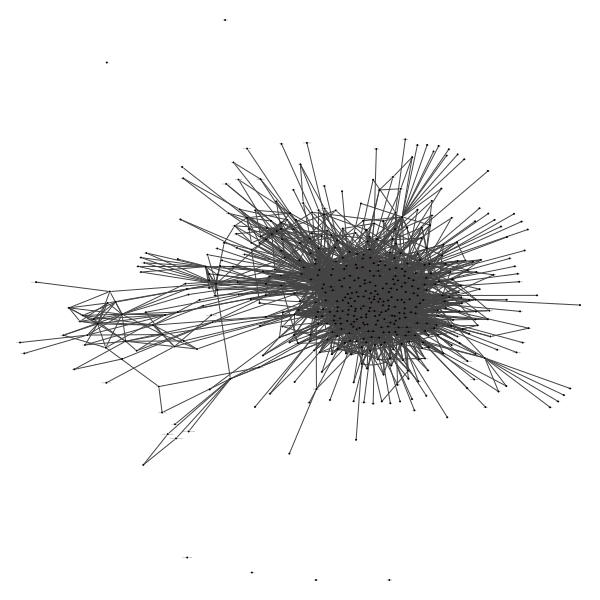

In [66]:
#data=[trace1, trace2]
#fig=go.Figure(data=data, layout=layout)
visual_style = {}
visual_style["vertex_size"] = 1
visual_style["vertex_label"] =labels
visual_style["vertex_label_size"] = 1
visual_style["edge_arrow_size"] = .1
ig.plot(G,**visual_style)